# Assignment 5: Statistical Analysis (30 pt)

Use as many Python and markdown cells per question as you deem necessary. **DO NOT SUBMIT CODE THAT DOES NOT RUN.** You will lose points for code that throws errors. 

Questions 1 and 2 will use data describing various wetlands, intertidal zones, and ocean conditions in the United States from 1972-2015. This data has been adapted from [publicly available coal from NASA](https://daac.ornl.gov/NACP/guides/Tidal_Wetland_Estuaries_Data.html). Note that this file uses the value `-9999` to denote missing data. This file's path is `data/tidal_wetland_estuaries.csv`.

Question 3 will be using time series data describing the proportion of electricity produced by coal in electricity_prod countries from [the World Bank](https://data.worldbank.org/indicator/EG.ELC.COAL.ZS). The path to the file is `data/coal-production.csv`.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults



data = pd.read_csv('./data/tidal_wetland_estuaries.csv')
coal = pd.read_csv('./data/coal-production.csv')

## Question 1: t-tests (10 pt)

Using the data from `tidal_wetland_estuaries.csv`, test the hypothesis that soil organic carbon density (column name: `soc_density`) is **larger** in the East coast than the West coast with a t-test. Interpret the t-test. (5 pt)

Defend your choice of which type of t-test you used (3 pt).

Do the data meet the requirement for normal data? Why or why not? (2 pt) 

## Question 2

Using the data from `tidal_wetland_estuaries.csv`, create a linear model to predict mean ocean salinity (column name: `ocean_salinity_mean`) from other environmental factors. (2 pt)

Create a model with a high R-squared value (> 0.80). All coefficients should be significant, and none should have VIF values above 5.0. (4 pt)

Interpret the summary of the model, focusing on the R-squared value and the regression coefficients. (3 pt)

Make diagnostic plots to ensure your data meets the assumptions of linear regression. The necessary functions have been imported for you. (1 pt).

                             OLS Regression Results                            
Dep. Variable:     ocean_salinity_mean   R-squared:                       1.000
Model:                             OLS   Adj. R-squared:                  1.000
Method:                  Least Squares   F-statistic:                 4.631e+26
Date:                 Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                         14:38:39   Log-Likelihood:                 2373.5
No. Observations:                  115   AIC:                            -4739.
Df Residuals:                      111   BIC:                            -4728.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.1

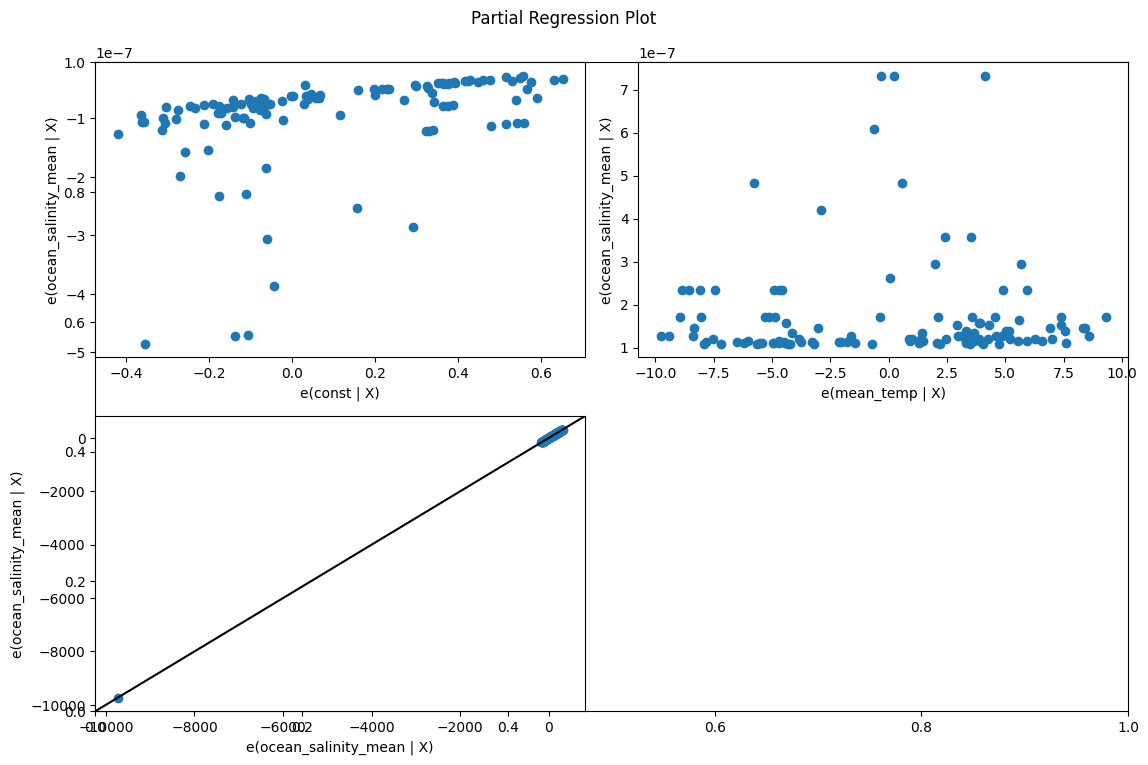

In [16]:
from utils import Linear_Reg_Diagnostic # do not change!

# select the predictors and response variable
x = data[['mean_temp', 'ocean_salinity_mean', 'tide_flow']]
y = data['ocean_salinity_mean']

# fit the linear model
model = sm.OLS(y, sm.add_constant(x)).fit()

# check the R-squared value and the significance of coefficients
print(model.summary())

# check VIF values
vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
print("VIF values:", vif)

# create diagnostic plots
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_partregress_grid(model, exog_idx=[0, 1, 2], fig=fig)
fig.tight_layout()
plt.show()


## Question 3 

Using the `coal-production.csv` data, model the proportion of electricity produced with coal in high income countries over time with an ARIMA model. 

Process the data to be useable for time series analysis. (2 pt)

Display your data. Does it appear to have a trend? If so, describe the trend. (1 pt)

Test for stationarity. (1 pt)

Make an ARIMA model of the time series, either by manually testing different types, or with an auto-ARIMA. What type of ARIMA model was found to be the best fit? (2 pt)

Visualize the fitted values of the ARIMA model, being sure to label each line. (2 pt)

Make a forecast for 25 years after the conclusion of the time series and visualize with observed and fitted values. (2 pt)

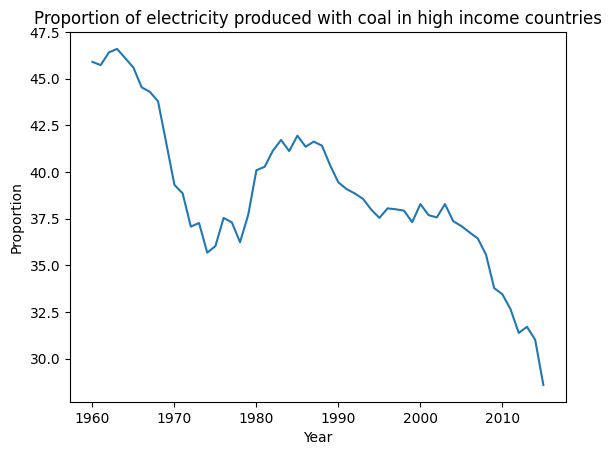

ADF Statistic: 1.872154
p-value: 0.998482


/home/matthew/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/matthew/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/matthew/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       electricity_prod   No. Observations:                   56
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -71.148
Date:                Thu, 04 May 2023   AIC                            152.296
Time:                        14:47:18   BIC                            162.333
Sample:                    01-01-1960   HQIC                           156.177
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1499      0.541      0.277      0.782      -0.911       1.210
ar.L2          0.5983      0.453      1.320      0.187      -0.290       1.486
ma.L1          0.1724      0.513      0.336      0.7

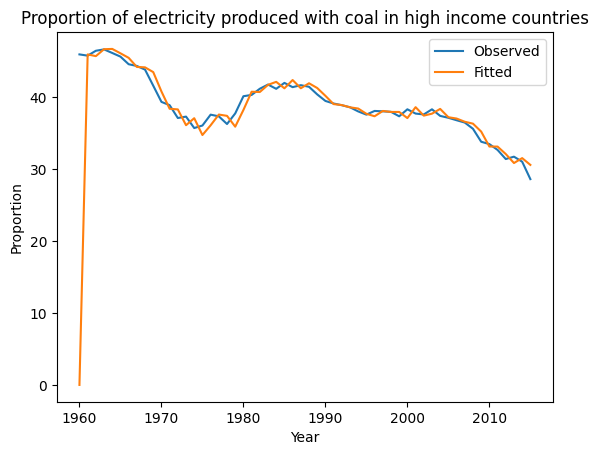

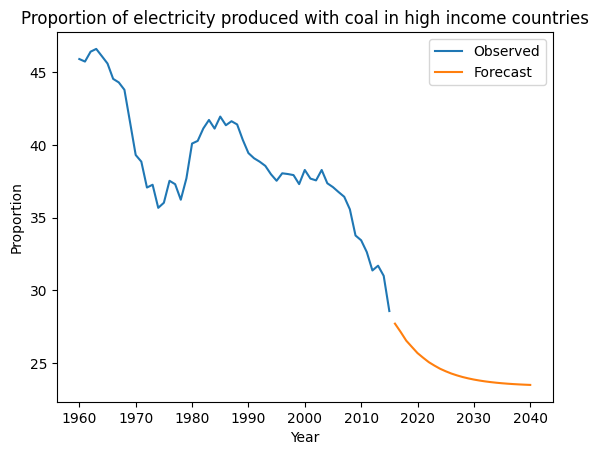

In [25]:
# convert the 'year' column to a datetime object and set it as the index
coal['year'] = pd.to_datetime(coal['year'], format='%Y')
coal = coal.set_index('year')

# convert the 'electricity_prod' column to a numeric type and fill missing values with 0
coal['electricity_prod'] = pd.to_numeric(coal['electricity_prod'], errors='coerce')
coal['electricity_prod'] = coal['electricity_prod'].fillna(0)

# display the data
plt.plot(coal)
plt.title("Proportion of electricity produced with coal in high income countries")
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.show()

# test for stationarity using the Augmented Dickey-Fuller test
result = adfuller(coal['electricity_prod'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# fit an ARIMA model
model = ARIMA(coal['electricity_prod'], order=(2, 1, 2))
results = model.fit()

# print the summary of the model
print(results.summary())

# visualize the fitted values of the ARIMA model
plt.plot(coal.index, coal['electricity_prod'], label='Observed')
plt.plot(results.fittedvalues.index, results.fittedvalues, label='Fitted')
plt.title("Proportion of electricity produced with coal in high income countries")
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.legend()
plt.show()

# make a forecast for 25 years after the conclusion of the time series
forecast = results.forecast(steps=25)
plt.plot(coal.index, coal['electricity_prod'], label='Observed')
plt.plot(forecast.index, forecast, label='Forecast')
plt.title("Proportion of electricity produced with coal in high income countries")
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.legend()
plt.show()
